# Timeseries simulation with pandapower

This is a demonstration of a timeseries simulation with pandapower. 

In [1]:
import pandapower as pp
import pandapower.plotting as plot

import os
import pandas as pd
from numpy import pi

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 14

First, the network model is loaded from an excel file, that was created in grid.ipynb, and the valid switching states for the network, that were analyzed in switch_evaluation.ipynb.
The load and generation time series used for this case study are loaded from a .csv file.


In [2]:
net = pp.from_excel(os.path.join("data", "case_study_grid.xlsx"))
sw = pd.read_json(os.path.join("results", "results_switches.json"))
time_series = pd.read_csv(os.path.join("data", "profiles.csv"), index_col="Time")
time_series.head()

,load,sgen
Time,,
00:00,0.0676,0.843750
00:15,0.0608,0.890625
00:30,0.0549,0.937500
00:45,0.0499,0.984375
01:00,0.0462,1.031250


The load time series is representing the H0 standard householf profile. The generation time series is artificially created only for demonstration purposes. The time series resolution is 15 minutes and the profile is analyzed for 24 hours.The following figure illustrates the time series. One can see, that there is a clear low load/high generation case between 3:00 and 4:00 and a clear high load/low generation case at 19:45. 

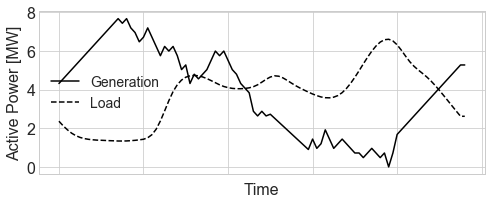

In [3]:
fig, ax = plt.subplots(figsize=(8, 3))
(abs(net.sgen.p_kw.sum()) * time_series.sgen * 1e-3).plot(ax=ax, color="k", style="-",)
(abs(net.load.p_kw.sum()) * time_series.load * 1e-3).plot(ax=ax, color="k", style="--",)
ax.legend(labels=["Generation", "Load"], loc=0)
ax.set_ylabel("Active Power [MW]")
plt.show()

The goal of the time series is now to optimize the switching state and the transformer tap postions of the grid for every time step. So, a function for the adaption of the transformer tap in case of voltage violations is defined. Voltage violations can be overvoltage or undervoltage.

In [4]:
import pandas as pd
import os

import pandapower as pp
import pandapower.topology as top

def overvoltage(net, area):
    return (net.res_bus.vm_pu.loc[area] > net.bus.max_vm_pu.loc[area]).any()

def undervoltage(net, area):
    return (net.res_bus.vm_pu.loc[area] < net.bus.min_vm_pu.loc[area]).any()

def get_all_tp_pos(net):
    return net.trafo.tp_pos.values.tolist() + net.trafo3w.tp_pos.values.tolist()

def adapt_taps(net):
    trafos = {2: ("trafo", 0), 8: ("trafo3w", 0), 14: ("trafo3w", 0)}
    areas = list(top.connected_components(top.create_nxgraph(net), set(trafos.keys())))
    pp.runpp(net)
    tp_positions = []
    while overvoltage(net, net.bus.index) or undervoltage(net, net.bus.index):
        tp_positions.append(get_all_tp_pos(net))
        for area in areas:
            trafo_bus = set(trafos.keys()) & set(area)
            if len(trafo_bus) != 1:
                continue
            trafo, idx = trafos[trafo_bus.pop()] #get the transformer relevant for voltage control in this feeder
            if overvoltage(net, area): #check for overvoltage in feeder
                if net[trafo].at[idx, "tp_pos"] < net[trafo].at[idx, "tp_max"]: #check if transformer is in saturation
                    net[trafo].at[idx, "tp_pos"] += 1 #tap up to decrease voltage
            if undervoltage(net, area): #check for udnervoltage in feeder
                if net[trafo].at[idx, "tp_pos"] > net[trafo].at[idx, "tp_min"]: #check if transformer is in saturation
                    net[trafo].at[idx, "tp_pos"] -= 1 #tap down to increase voltage
        pp.runpp(net)
        if get_all_tp_pos(net) in tp_positions:
            break
    return not overvoltage(net, net.bus.index) and not undervoltage(net, net.bus.index)

Now, the function simulate_timestep is created, that iterates through all valid switching states for one time step. Then for each switching state, first the voltage is optimized and then the line and transformer loadings are checked. If the voltage profile is valid and no line and no transformer is overloaded, the respective switching state is considered valid for the current time step. At the end of the time step, the valid switching with the lowest losses is considered to be the the optimal switching state for this time step and is returned by this function.

In [5]:
def simulate_timestep(net, sw):
    results = pd.DataFrame(columns=["switches", "losses", "max_line_loading", "max_trafo_loading",
                                    "min_voltage", "max_voltage","tp_2w", "tp_3w", "min_sc"])
    for i, par in sw[sw.valid].iterrows():
        net.switch.closed = True
        net.switch.closed.loc[par.switches] = False
        voltage_valid = adapt_taps(net)
        line_loading_valid = (net.res_line.loading_percent < net.line.max_loading_percent).all()
        trafo_loading_valid = (net.res_trafo.loading_percent < net.trafo.max_loading_percent).all()
        if not voltage_valid or not line_loading_valid or not trafo_loading_valid:
            continue
        results.loc[i] = [par.switches, abs(net.res_bus.p_kw.sum()) / 4., net.res_line.loading_percent.max(),
                          net.res_trafo.loading_percent.max(), net.res_bus[net.bus.vn_kv < 100].vm_pu.min(),
                          net.res_bus[net.bus.vn_kv < 100].vm_pu.max(), net.trafo.tp_pos.iloc[0],
                          net.trafo3w.tp_pos.iloc[0], par.min_sc]
    return results.sort_values("losses").iloc[0]

The function run_timeseries adapts the scaling factors of the loads and generators according to the specified time series and then analyzes all switching states through the function simulate_timestep explained above. 

In [6]:
def run_timeseries(net, sw, time_series):   
    results = dict()
    for t, step in time_series.iterrows():
        print("Timestep %s" % t)
        net.sgen.scaling = step.sgen
        net.load.scaling = step.load
        results[t] = simulate_timestep(net, sw)
    return pd.DataFrame(results).T

The results from the timeseries simulation can also be obtained from the already included result file. To do so just change the load_from_disk parameter to True. Otherwise, now the run_timeseries will be called and actually conduct the time series simulation.

In [7]:
load_from_disk = False
if load_from_disk:
    results = pd.read_json(os.path.join("results", "results_timeseries.json"), convert_axes=False)    
else:
    results = run_timeseries(net, sw, time_series)

Timestep 00:00
Timestep 00:15
Timestep 00:30
Timestep 00:45
Timestep 01:00
Timestep 01:15
Timestep 01:30
Timestep 01:45
Timestep 02:00
Timestep 02:15
Timestep 02:30
Timestep 02:45
Timestep 03:00
Timestep 03:15
Timestep 03:30
Timestep 03:45
Timestep 04:00
Timestep 04:15
Timestep 04:30
Timestep 04:45
Timestep 05:00
Timestep 05:15
Timestep 05:30
Timestep 05:45
Timestep 06:00
Timestep 06:15
Timestep 06:30
Timestep 06:45
Timestep 07:00
Timestep 07:15
Timestep 07:30
Timestep 07:45
Timestep 08:00
Timestep 08:15
Timestep 08:30
Timestep 08:45
Timestep 09:00
Timestep 09:15
Timestep 09:30
Timestep 09:45
Timestep 10:00
Timestep 10:15
Timestep 10:30
Timestep 10:45
Timestep 11:00
Timestep 11:15
Timestep 11:30
Timestep 11:45
Timestep 12:00
Timestep 12:15
Timestep 12:30
Timestep 12:45
Timestep 13:00
Timestep 13:15
Timestep 13:30
Timestep 13:45
Timestep 14:00
Timestep 14:15
Timestep 14:30
Timestep 14:45
Timestep 15:00
Timestep 15:15
Timestep 15:30
Timestep 15:45
Timestep 16:00
Timestep 16:15
Timestep 1

The result table contains the optimal switching states, the respective losses, the maximum line and transformer loading, the maximum and minimum voltage in the network for each time step, the tap psitions and the minimum short circuit current:

In [8]:
results.head()

,switches,losses,max_line_loading,max_trafo_loading,min_voltage,max_voltage,tp_2w,tp_3w,min_sc
00:00,"[4, 6]",18.8864,15.1988,15.5489,0.971995,0.991426,2,2,1.19545
00:15,"[5, 6]",20.3014,20.394,18.2854,0.972036,0.994973,2,2,1.19545
00:30,"[5, 6]",22.0448,25.223,20.8576,0.972037,0.998474,2,2,1.19545
00:45,"[5, 6]",24.0157,29.6729,23.2667,0.972029,1.00157,2,2,1.19545
01:00,"[5, 6]",26.0408,33.5774,25.4426,0.972013,1.00415,2,2,1.19545


The following figure shows the overall active power losses in the network:

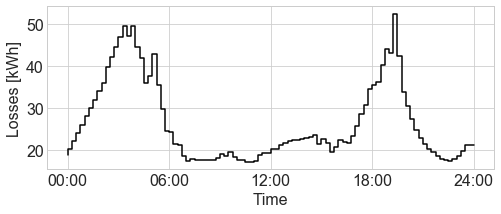

In [9]:
fig, ax = plt.subplots(figsize=(8, 3))
results.losses.plot(ax=ax, color="k", style="-", drawstyle="steps")
ax.set_ylabel("Losses [kWh]")
ax.set_xticks([i for i in range(len(results.index))][::24])
plt.xticks([i for i in range(len(results.index))][::24], results.index[::24])
ax.set_xlabel('Time')
plt.show()

The following plots illustrate the maximum line and transformer loading in the network througout the day:

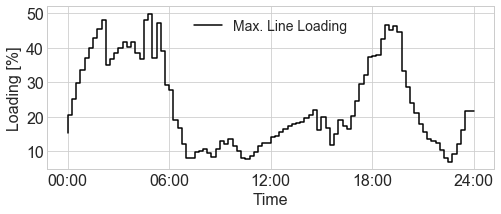

In [10]:
fig, ax = plt.subplots(figsize=(8, 3))
results.max_line_loading.plot(ax=ax, color="k", style="-", drawstyle="steps")
ax.set_ylabel("Loading [%]")
ax.legend(labels=["Max. Line Loading"], loc=0)
ax.set_xticks([i for i in range(len(results.index))][::24])
plt.xticks([i for i in range(len(results.index))][::24], results.index[::24])
ax.set_xlabel('Time')
plt.show()

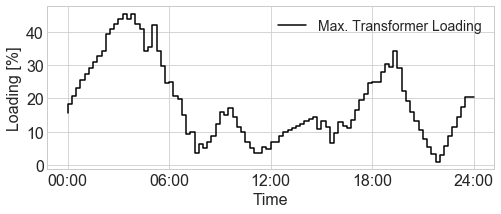

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))
results.max_trafo_loading.plot(ax=ax, color="k", style="-", drawstyle="steps")
ax.set_ylabel("Loading [%]")
ax.legend(labels=["Max. Transformer Loading"], loc=0)
ax.set_xticks([i for i in range(len(results.index))][::24])
plt.xticks([i for i in range(len(results.index))][::24], results.index[::24])
ax.set_xlabel('Time')
plt.show()

Here one can see the maximum and minumim voltage for each time step. It can be noted that the voltage is always between the specified limits of 1.03 p.u. and .97 p.u.

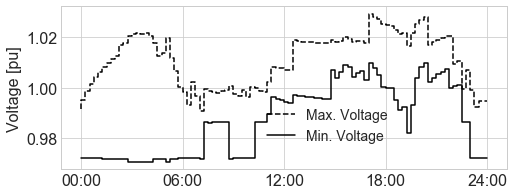

In [12]:
fig, ax = plt.subplots(figsize=(8, 3))
results.max_voltage.plot(ax=ax, color="k", style="--", drawstyle="steps")
results.min_voltage.plot(ax=ax, color="k", style="-", drawstyle="steps")
ax.legend(labels=["Max. Voltage", "Min. Voltage"], bbox_to_anchor=(.76, 0.455), loc=1)
ax.set_ylabel("Voltage [pu]")
ax.set_xticks([i for i in range(len(results.index))][::24])
plt.xticks([i for i in range(len(results.index))][::24], results.index[::24])
plt.show()

Looking at the transformer tap positions, one can see that the taps are stepped down with increasing load and decreasing generation during the day.

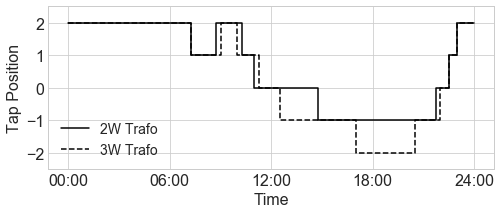

In [13]:
fig, ax = plt.subplots(figsize=(8, 3))
results.tp_2w.plot(ax=ax, color="k", style="-", drawstyle="steps")
results.tp_3w.plot(ax=ax, color="k", style="--", drawstyle="steps")
ax.legend(labels=["2W Trafo", "3W Trafo"], loc=0)
ax.set_ylabel("Tap Position")
ax.set_ylim(-2.5, 2.5)
ax.set_xticks([i for i in range(len(results.index))][::24])
plt.xticks([i for i in range(len(results.index))][::24], results.index[::24])
ax.set_xlabel('Time')
plt.show()

The short cisuit currents are compliant as well, they are over the minimum value of 1.1 all day.

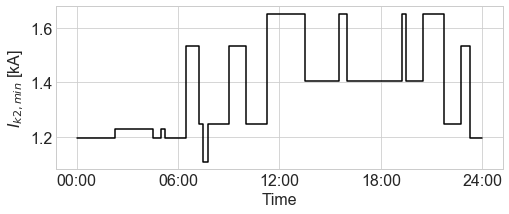

In [14]:
fig, ax = plt.subplots(figsize=(8, 3))
results.min_sc.plot(ax=ax, color="k", style="-", drawstyle="steps")
ax.set_ylabel("$I_{k2, min}$ [kA]")
ax.set_xticks([i for i in range(len(results.index))][::24])
plt.xticks([i for i in range(len(results.index))][::24], results.index[::24])
ax.set_xlabel('Time')
plt.show()

This figure shows the resulting switching states from the optimization. Out of the overall 80 valid switching states from the switch_evaluation.ipynb, 11 switching states are applied in the time series simulation.

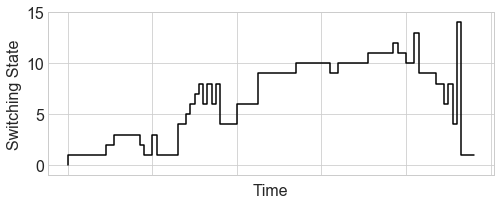

In [15]:
fig, ax = plt.subplots(figsize=(8, 3))
results.switches = results.switches.apply(tuple)
switching_states = results.switches.unique().tolist()
results.switches.apply(switching_states.index).plot(ax=ax, color="k", drawstyle="steps")
ax.set_ylabel("Switching State")
ax.set_ylim(-1., len(switching_states))
ax.set_xlabel('Time')
plt.show()

Here the function set_state is defined, that sets the switching state, the right scalings for loads and generators and the optimized tap positions in the network model for one specific time step and executes the load flow calculation for this time step.

In [16]:
def set_state(net, results, time_series, time):
    result = results.loc[time]
    net.switch.closed = True
    net.switch.loc[result.switches, "closed"] = False
    net.trafo.tp_pos = result.tp_2w
    net.trafo3w.tp_pos = result.tp_3w
    net.sgen.scaling = time_series.loc[result.name, "sgen"]
    net.load.scaling = time_series.loc[result.name, "load"]
    pp.runpp(net)

So finally, the function plot_grid_state is introduced, that illustrates the grid state for one network configuration:

In [17]:
def plot_grid_state(net):
    tie_lines = set(net.switch.element[~net.switch.closed.values].values)
    lines = set(net.line.index) - tie_lines

    #plot buses
    bc = plot.create_bus_collection(net, size=.04, zorder=10, color="b")

    #plot lines with switches
    cmap, norm = plot.cmap_discrete([((0, 35), "g"), ((35, 70), "y"), ((70,80), "r")])
    lc = plot.create_line_collection(net, lines, linewidths=3., use_bus_geodata=True, color="grey",
                                     cmap=cmap, norm=norm)
    olr = plot.create_line_collection(net, lines=tie_lines, color='grey', linewidths=2.0,
                                      use_bus_geodata=True, linestyles="dashed")
    sc = plot.create_line_switch_collection(net, size=0.1, distance_to_bus=.12, use_line_geodata=True,
                                            zorder=12, color="k")

    #plot transformers
    t31, t32 = plot.create_trafo3w_collection(net, linewidths=2.)
    t21, t22 = plot.create_trafo_collection(net, linewidths=2.)

    #plot load and generation elements
    sl1, sl2 = plot.create_ext_grid_collection(net, size=0.4, orientation=3*pi/2, linewidths=2.)
    plot.draw_collections([bc, lc, olr, sc, t21, t22, t31, t32, sl1, sl2], figsize=(12,3))
    plt.show()

With these two functions, the grid state for a single time step can be depicted. Here for the low load/high generation case:

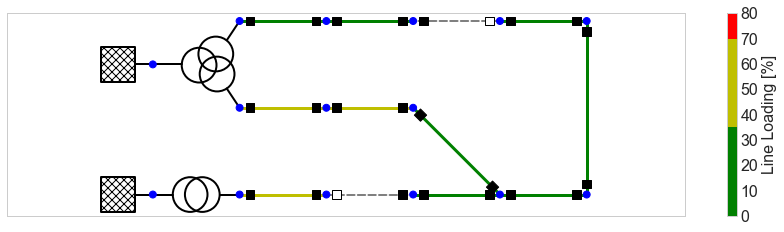

In [18]:
set_state(net, results, time_series, "03:30")
plot_grid_state(net)

And for the high load/low generation case:

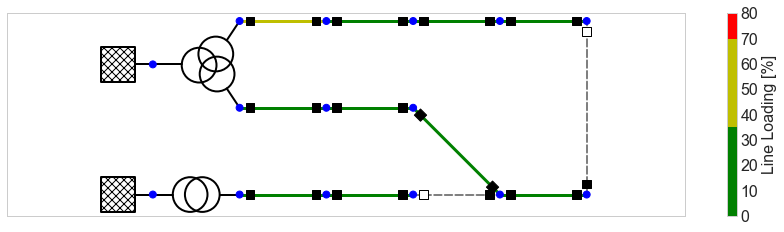

In [19]:
set_state(net, results, time_series, "19:15")
plot_grid_state(net)